# First Architecture

This is a simple perceptron architecture with only one layer.

In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

## Load Data

In [6]:
df_train = pd.read_csv('data/raw/lithology.csv', sep=';')
df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


In [2]:
def lithology_number_to_name(x):
    if x == 30000.0:
        return 'Sandstone'
    elif x == 65030.0:
        return 'Sandstone/Shale'
    elif x == 65000.0:
        return 'Shale'
    elif x == 80000.0:
        return 'Marl'
    elif x == 74000.0:
        return 'Dolomite'
    elif x == 70000.0:
        return 'Limestone'
    elif x == 70032.0:
        return 'Chalk'
    elif x == 88000.0:
        return 'Halite'
    elif x == 86000.0:
        return 'Anhydrite'
    elif x == 99000.0:
        return 'Tuff'
    elif x == 90000.0:
        return 'Coal'
    elif x == 93000.0:
        return 'Basement'
    else: raise ValueError('Category Not Found')

df_train = df_train.assign(FORCE_2020_LITHOFACIES_LITHOLOGY_CAT = df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.apply(lambda x: lithology_number_to_name(x)))

df_train.head()

NameError: name 'df_train' is not defined

In [8]:
df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [3]:
def get_values_from_category(df_train, n_samples=1000):
    '''
    Get the same values (or all if it has less than) of all categories. The idea is to balance dataset
    '''

    df_data = pd.DataFrame()

    for cat in df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.unique():
        df_data = df_data.append(df_train[df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT == cat].iloc[0:n_samples])
    
    return df_data

In [4]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

def transform_data(X_train, X_test, X_val, y_train, y_test, y_val):
    scl = MinMaxScaler()
    oe = OrdinalEncoder()

    X_train_transform = scl.fit_transform(X_train)
    X_test_transform = scl.transform(X_test)
    X_val_transform = scl.transform(X_val)

    y_train_enc = oe.fit_transform(y_train)
    y_test_enc = oe.transform(y_test)
    y_val_enc = oe.transform(y_val)

    return X_train_transform, X_test_transform, X_val_transform, y_train_enc, y_test_enc, y_val_enc

In [5]:
def get_class_distribution(obj):
    count_dict = {
        'Anhydrite': 0, 
        'Basement': 0, 
        'Chalk': 0, 
        'Coal': 0, 
        'Dolomite': 0, 
        'Halite': 0,
        'Limestone': 0, 
        'Marl': 0, 
        'Sandstone': 0, 
        'Sandstone/Shale': 0, 
        'Shale': 0,
        'Tuff': 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Anhydrite'] += 1
        elif i == 1: 
            count_dict['Basement'] += 1
        elif i == 2: 
            count_dict['Chalk'] += 1
        elif i == 3: 
            count_dict['Coal'] += 1
        elif i == 4: 
            count_dict['Dolomite'] += 1  
        elif i == 5: 
            count_dict['Halite'] += 1
        elif i == 6: 
            count_dict['Limestone'] += 1                    
        elif i == 7: 
            count_dict['Marl'] += 1
        elif i == 8: 
            count_dict['Sandstone'] += 1
        elif i == 9: 
            count_dict['Sandstone/Shale'] += 1
        elif i == 10: 
            count_dict['Shale'] += 1
        elif i == 11: 
            count_dict['Tuff'] += 1
        else:
            print("Check classes.")
            
    return count_dict

### Architectures To Evaluate

In [6]:
#single_layer
class SingleLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(SingleLayerSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

# multi_layer
class MultiLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_out(x)
        return x

# multi_layer_relu
class MultiLayerReLUSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerReLUSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.relu(x)

        x = self.layer_out(x)
        return x

# multi_layer_relu_batch_norm
class MultiLayerReLUBatchNormSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerReLUBatchNormSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        
        self.relu = nn.ReLU()
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.batch_norm_2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)

        x = self.layer_out(x)
        return x

# multi_layer_relu_batch_norm_dropout
class MultiLayerReLUBatchNormDropoutSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerReLUBatchNormDropoutSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.batch_norm_2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        return x
    
# multi_layer_3_relu_batch_norm_dropout
class MultiLayer3ReLUBatchNormDropoutSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayer3ReLUBatchNormDropoutSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        return x    

In [7]:
def load_model(model_name, num_features, num_classes):
    if model_name == 'single_layer':
        return SingleLayerSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer':
        return MultiLayerSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_relu':
        return MultiLayerReLUSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_relu_batch_norm':
        return MultiLayerReLUBatchNormSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_relu_batch_norm_dropout':
        return MultiLayerReLUBatchNormDropoutSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_3_relu_batch_norm_dropout':
        return MultiLayer3ReLUBatchNormDropoutSoftmax(num_features, num_classes)

### Creating a simple model

Model created thanks to this documentation: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [8]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

def fit_model(
    X_train, y_train, X_test, y_test, X_val, y_val, 
    epochs=5, batch_size=16, num_classes=12, learning_rate=0.05,
    model_name='single_layer'
):
    NUM_FEATURES = len(X.columns)
    NUM_CLASSES = 12

    train_dataset = ClassifierDataset(
        torch.from_numpy(X_train.astype(np.float32)), 
        torch.from_numpy(y_train.reshape(-1)).long()
    )

    val_dataset = ClassifierDataset(
        torch.from_numpy(X_val.astype(np.float32)), 
        torch.from_numpy(y_val.reshape(-1)).long()
    )

    test_dataset = ClassifierDataset(
        torch.from_numpy(X_test.astype(np.float32)), 
        torch.from_numpy(y_test.reshape(-1)).long()
    )

    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]

    # Due to unbalanced data, create weights to classes
    class_count = [i for i in get_class_distribution(y_train).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float)

    class_weights_all = class_weights[target_list]
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=weighted_sampler
    )

    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = load_model(model_name, NUM_FEATURES, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(model)

    accuracy_stats = {
        'train': [],
        'val': []
    }

    loss_stats = {
        'train': [],
        'val': []
    }

    print('Begin training')

    # Using tqdm to show the loading
    for e in tqdm(range(1, epochs+1)):
        # Training
        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        
        # Validation
        with torch.no_grad():
            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:

                y_val_pred = model(X_val_batch)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        
        train_loss = train_epoch_loss/len(train_loader)
        val_loss = val_epoch_loss/len(val_loader)

        train_acc = train_epoch_acc/len(train_loader)
        val_acc = val_epoch_acc/len(val_loader)

        loss_stats['train'].append(train_loss)
        loss_stats['val'].append(val_loss)
        accuracy_stats['train'].append(train_acc)
        accuracy_stats['val'].append(val_acc)
        print(f'''Epoch {e+0:03}: | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | 
        Train Acc: {train_acc:.3f}% | Val Acc: {val_acc:.3f}%''')

    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index": "epochs"})

    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index": "epochs"})

    # Plotting Accuracy and Loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x='epochs', y='value', hue='variable', ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x='epochs', y='value', hue='variable', ax=axes[1]).set_title('Train-Val Loss/Epoch')

    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim=1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    idx2class = {
        0: 'Anhydrite', 
        1: 'Basement', 
        2: 'Chalk', 
        3: 'Coal', 
        4: 'Dolomite', 
        5: 'Halite',
        6: 'Limestone', 
        7: 'Marl', 
        8: 'Sandstone', 
        9: 'Sandstone/Shale', 
        10: 'Shale',
        11: 'Tuff'
    }

    # Confusion Matrix
    # ax = plt.subplot()
    plt.figure()
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
    # sns.heatmap(confusion_matrix_df, annot=True, fmt='g', ax=ax)
    sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

    print(classification_report(y_test, y_pred_list))

    return model

### SMOTE all dataset

In [28]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()


df_partial_data = df_train.query("FORCE_2020_LITHOFACIES_LITHOLOGY_CAT in ['Marl', 'Tuff', 'Chalk', 'Halite', 'Coal', 'Dolomite', 'Anhydrite', 'Basement']")
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

X_balanced, y_balanced = oversample.fit_resample(X, Y)

Marl         33329
Tuff         15245
Chalk        10513
Halite        8213
Coal          3820
Dolomite      1688
Anhydrite     1085
Basement       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64


In [31]:
df_balanced_data = df_train.query("FORCE_2020_LITHOFACIES_LITHOLOGY_CAT not in ['Marl', 'Tuff', 'Chalk', 'Halite', 'Coal', 'Dolomite', 'Anhydrite', 'Basement']")

In [33]:
# df_balanced_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

X1 = df_balanced_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y1 = df_balanced_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

In [35]:
X_balanced = X_balanced.append(X1)
y_balanced = y_balanced.append(Y1)

In [3]:
y_balanced.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

NameError: name 'y_balanced' is not defined

In [37]:
X_balanced.to_csv('data/raw/X_sub_augmented.csv')
y_balanced.to_csv('data/raw/y_sub_augmented.csv')

### Test 7

In [9]:
X_balanced = pd.read_csv('data/raw/X_sub_augmented.csv', index_col='Unnamed: 0')
y_balanced = pd.read_csv('data/raw/y_sub_augmented.csv', index_col='Unnamed: 0')

/Users/leonardofiedler/Desenvolvimento/neural_network/.venv/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
y_balanced.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Anhydrite           33329
Coal                33329
Basement            33329
Marl                33329
Halite              33329
Chalk               33329
Tuff                33329
Dolomite            33329
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [11]:
df_data_balanced = X_balanced.join(y_balanced)
df_data_balanced.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,2198.296,437622.28125,6470981.0,-2172.966553,23.249596,-999.0,0.474248,0.447025,1.677679,48.699841,...,0.179283,0.086253,-0.002747,0.001873,-1.837376,0.152,0.102723,7,4,Tuff
0,2198.296,437622.28125,6470981.0,-2172.966553,23.249596,-999.0,0.474248,0.447025,1.677679,48.699841,...,0.179283,0.086253,-0.002747,0.001873,-1.837376,0.152,0.102723,7,4,Shale
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Tuff
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Tuff


Marl               20000
Chalk              20000
Tuff               20000
Coal               20000
Limestone          20000
Anhydrite          20000
Dolomite           20000
Shale              20000
Basement           20000
Halite             20000
Sandstone/Shale    20000
Sandstone          20000
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayer3ReLUBatchNormDropoutSoftmax(
  (layer_1): Linear(in_features=30, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

  0%|          | 0/300 [00:00<?, ?it/s]

: 0.62073 | 
        Train Acc: 69.168% | Val Acc: 72.602%
Epoch 114: | Train Loss: 0.76680 | Val Loss: 0.63027 | 
        Train Acc: 68.914% | Val Acc: 71.940%
Epoch 115: | Train Loss: 0.75929 | Val Loss: 0.62268 | 
        Train Acc: 69.184% | Val Acc: 72.073%
Epoch 116: | Train Loss: 0.76244 | Val Loss: 0.62747 | 
        Train Acc: 69.181% | Val Acc: 72.250%
Epoch 117: | Train Loss: 0.76184 | Val Loss: 0.63402 | 
        Train Acc: 69.088% | Val Acc: 71.846%
Epoch 118: | Train Loss: 0.76653 | Val Loss: 0.65456 | 
        Train Acc: 68.919% | Val Acc: 71.508%
Epoch 119: | Train Loss: 0.76414 | Val Loss: 0.63072 | 
        Train Acc: 69.010% | Val Acc: 71.745%
Epoch 120: | Train Loss: 0.76179 | Val Loss: 0.61377 | 
        Train Acc: 69.201% | Val Acc: 72.727%
Epoch 121: | Train Loss: 0.76032 | Val Loss: 0.62152 | 
        Train Acc: 69.182% | Val Acc: 72.250%
Epoch 122: | Train Loss: 0.76053 | Val Loss: 0.63813 | 
        Train Acc: 69.336% | Val Acc: 72.034%
Epoch 123: | Train Loss

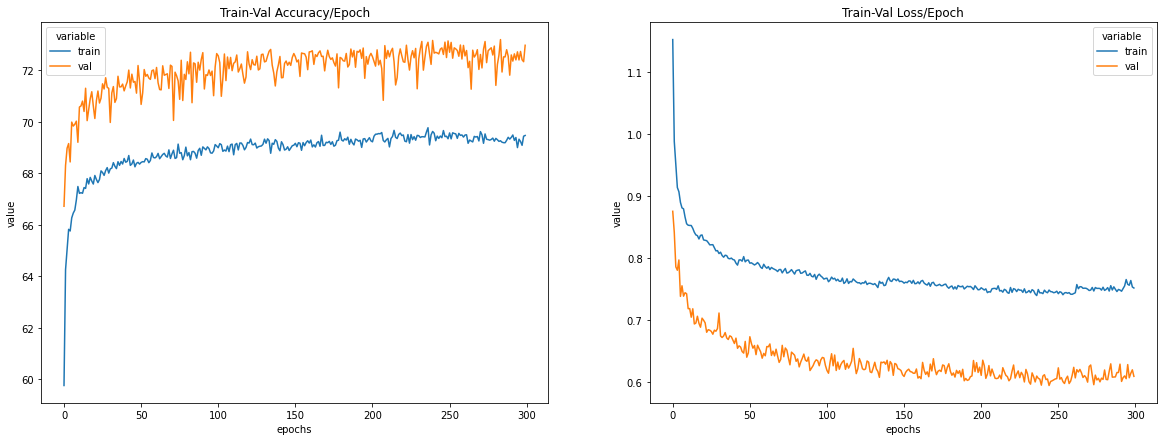

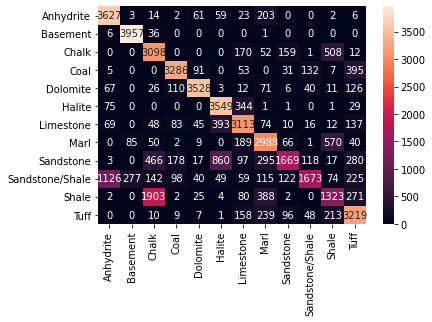

In [14]:
# Testing with all data
df_partial_data = get_values_from_category(df_data_balanced, n_samples=20000)
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

model = fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=300, batch_size=32, num_classes=12, learning_rate=0.03,
    model_name='multi_layer_3_relu_batch_norm_dropout'
)

### Saving Model

In [16]:
def save_model(model, file_name):
    torch.save(model, file_name)

save_model(model, 'data/model/test_7.pth')    